Classifying reviews as fake or real using machine learning

In [2]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

loading data and exploring data

In [3]:
#loading preprocessed data
data = pd.read_csv(r"C:\Users\Nithin Srinivaas\OneDrive\Documents\Fake_Review_Project\TP_DS.csv")

In [4]:
df = data
df.head()

,category,rating,label,text_,cleaned_text
0,Home_and_Kitchen_5,5.0,CG,"['love', 'well', 'made', 'sturdi', 'comfort', ...",love well made sturdi comfort love pretti
1,Home_and_Kitchen_5,5.0,CG,"['love', 'great', 'upgrad', 'origin', ""'ve"", '...",love great upgrad origin 've mine coupl year
2,Home_and_Kitchen_5,5.0,CG,"['pillow', 'save', 'back', 'love', 'look', 'fe...",pillow save back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,"['miss', 'inform', 'use', 'great', 'product', ...",miss inform use great product price
4,Home_and_Kitchen_5,5.0,CG,"['nice', 'set', 'good', 'qualiti', 'set', 'two...",nice set good qualiti set two month


In [5]:
# dropping text_ column as it contains raw textual data and focussing on cleaned_text 
df.drop('text_',axis=1,inplace= True)

In [6]:
df.head()

,category,rating,label,cleaned_text
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love pretti
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin 've mine coupl year
2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price
4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month


#dropping null values if any

In [7]:
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      40431 non-null  object 
 1   rating        40431 non-null  float64
 2   label         40431 non-null  object 
 3   cleaned_text  40431 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


#creating a length column which computes the length( no of characters)in each row

In [9]:
df['length'] = df['cleaned_text'].apply(len)

#plotting the Histogram that represents distribution of length of cleaned_text_column

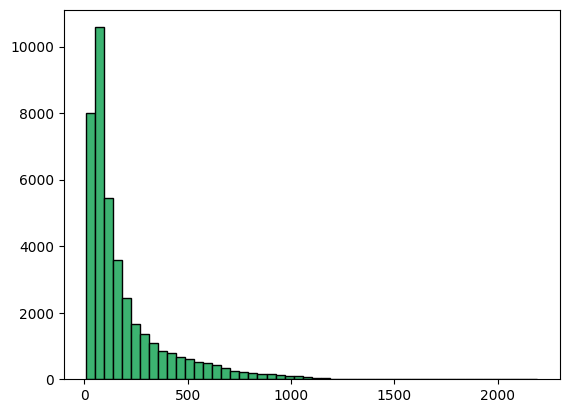

In [10]:
plt.hist(df['length'],bins=50,color='#3CB371', edgecolor='black')
plt.show()

#summary statistics for numerical columns within each group (label)

In [11]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20215.0  4.259906  1.141092  1.0  4.0  5.0  5.0  5.0  20215.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                
             mean         std  min   25%    50%    75%     max  
label                                                           
CG     156.697452  158.315698  9.0  51.0   89.0  195.0  1198.0  
OR     222.869311  239.511782  8.0  69.0  125.0  276.0  2190.0

#Plotting Histogram that represents distribution of length of label groups(CG,OR)

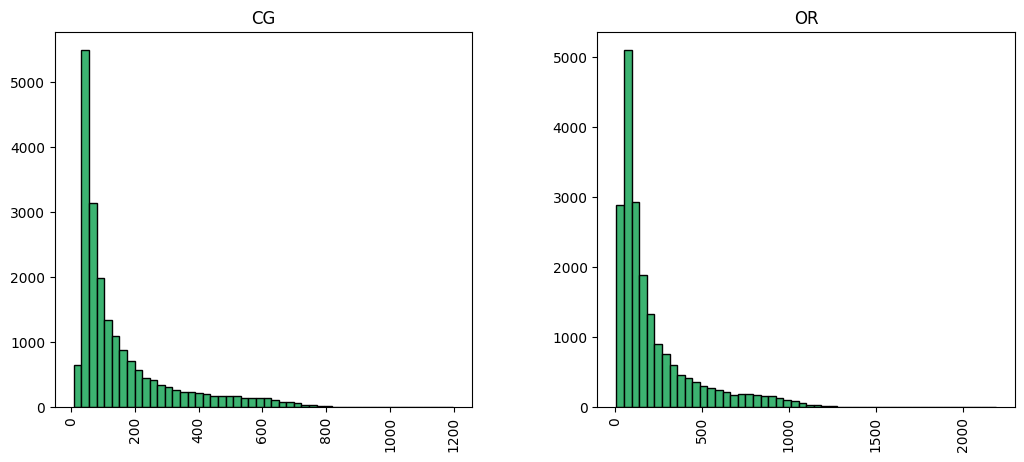

In [12]:
df.hist(column='length',by='label',bins=50,color='#3CB371',edgecolor='black',figsize=(12,5))
plt.show()

In [13]:
df.length.describe()

count    40431.000000
mean       189.784200
std        205.691426
min          8.000000
25%         58.000000
50%        106.000000
75%        232.000000
max       2190.000000
Name: length, dtype: float64

In [14]:
#define a text_process function that Removes punctuation, Splits the text into words,Removes common stopwords.
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Bag of Words (BoW) Transformation

using CountVectorizer from scikit-learn to convert the preprocessed text into a Bag of Words representation, where-Each word in the corpus is treated as a feature,the frequency of each word in a document is counted

In [15]:
# Bag of Words 
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,<function tex...0027F7F018040>


#printing the number of unique words in your vocabulary, which corresponds to the number of distinct features

In [16]:
bow_transformer.fit(df['cleaned_text'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 34502


In [17]:
review1 = df['cleaned_text'][0]
review1

'love well made sturdi comfort love pretti'

Convert (review1) into a numerical Bag of Words representation, based on the vocabulary learned earlier from the entire dataset

Sparse Matrix Output

In [18]:
bow_msg1 = bow_transformer.transform([review1])
print(bow_msg1)
print(bow_msg1.shape)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 34502)>
  Coords	Values
  (0, 7332)	1
  (0, 18426)	2
  (0, 18704)	1
  (0, 23874)	1
  (0, 29268)	1
  (0, 33253)	1
(1, 34502)


In [19]:
print(bow_transformer.get_feature_names_out()[18426])
print(bow_transformer.get_feature_names_out()[23874])

love
pretti


In [20]:
bow_reviews = bow_transformer.transform(df['cleaned_text'])

In [21]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40431, 34502)
Amount of non zero values in the bag of words model: 1001954


In [22]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.07


Transforms the BoW representation of the specific review (bow_msg1) into its TF-IDF representation

BoW counts the occurrences of words, while TF-IDF adjusts these counts based on how common or rare a word is across all documents

In [23]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_rev4 = tfidf_transformer.transform(bow_msg1)
print(bow_msg1)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (1, 34502)>
  Coords	Values
  (0, 7332)	1
  (0, 18426)	2
  (0, 18704)	1
  (0, 23874)	1
  (0, 29268)	1
  (0, 33253)	1


In [24]:
# accessing the IDF (Inverse Document Frequency) values for specific words
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['food']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['pretti']])

5.003433005027503
4.00547486975281


IDF Values: High IDF values suggest that a word is rare across the corpus, making it more important for a specific document. Low IDF values indicate that the word is common across many documents, making it less informative for distinguishing between documents.

The IDF values help adjust the raw term frequencies (from the BoW model) to make the features more meaningful when building machine learning models.

In [25]:
# Transforming the Entire Corpus
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40431, 34502)
No. of Dimensions: 2


classification using Machine learning models

text classification using a Multinomial Naive Bayes (MultinomialNB) model.

In [26]:
# MultinominalNB

# Assuming 'cleaned_text' is your TF-IDF feature matrix and 'label' contains the target values
# Split the data into training and test sets (e.g., 80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

# Create the pipeline with CountVectorizer, TfidfTransformer, and MultinomialNB
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),    # Convert text to Bag of Words
    ('tfidf', TfidfTransformer()),                      # Transform BOW to TF-IDF
    ('classifier', MultinomialNB())                     # Train the Naive Bayes classifier
])
# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
mn_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, mn_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, mn_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, mn_pred))

print('Model Prediction Accuracy:',str(np.round(accuracy_score(y_test,mn_pred)*100,2)) + '%')

Accuracy: 0.847656733028317
Classification Report:
               precision    recall  f1-score   support

          CG       0.82      0.88      0.85      4018
          OR       0.87      0.81      0.84      4069

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Confusion Matrix:
 [[3542  476]
 [ 756 3313]]
Model Prediction Accuracy: 84.77%


text classification using a Random Forest Classifier model.

In [27]:
# RandomForestClassifier

# Assuming 'cleaned_text' is your TF-IDF feature matrix and 'label' contains the target values
# Split the data into training and test sets (e.g., 80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

# Create the pipeline with CountVectorizer, TfidfTransformer, and Randomforest
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),    # Convert text to Bag of Words
    ('tfidf', TfidfTransformer()),                      # Transform BOW to TF-IDF
    ('classifier', RandomForestClassifier())             # Train the RandomForest classifier
])
# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
rf_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, rf_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))

print('Model Prediction Accuracy:',str(np.round(accuracy_score(y_test,rf_pred)*100,2)) + '%')

Accuracy: 0.8451836280450105
Classification Report:
               precision    recall  f1-score   support

          CG       0.82      0.88      0.85      4018
          OR       0.87      0.81      0.84      4069

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Confusion Matrix:
 [[3540  478]
 [ 774 3295]]
Model Prediction Accuracy: 84.52%


text classification using DecisionTreeClassifier model

In [28]:
# DecisionTreeClassifier

# Assuming 'cleaned_text' is your TF-IDF feature matrix and 'label' contains the target values
# Split the data into training and test sets (e.g., 80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

# Create the pipeline with CountVectorizer, TfidfTransformer, and DecisonTree
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),    # Convert text to Bag of Words
    ('tfidf', TfidfTransformer()),                      # Transform BOW to TF-IDF
    ('classifier', DecisionTreeClassifier())            # Train the DecisionTree classifier
])
# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
dt_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, dt_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, dt_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))

print('Model Prediction Accuracy:',str(np.round(accuracy_score(y_test,dt_pred)*100,2)) + '%')

Accuracy: 0.7406949425003091
Classification Report:
               precision    recall  f1-score   support

          CG       0.73      0.75      0.74      4018
          OR       0.75      0.73      0.74      4069

    accuracy                           0.74      8087
   macro avg       0.74      0.74      0.74      8087
weighted avg       0.74      0.74      0.74      8087

Confusion Matrix:
 [[3022  996]
 [1101 2968]]
Model Prediction Accuracy: 74.07%


text classification using K-Nearest Neighbors (KNN) model

In [29]:
# KNN

# Assuming 'cleaned_text' is your TF-IDF feature matrix and 'label' contains the target values
# Split the data into training and test sets (e.g., 80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

# Create the pipeline with CountVectorizer, TfidfTransformer, and KNN
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),    # Convert text to Bag of Words
    ('tfidf', TfidfTransformer()),                      # Transform BOW to TF-IDF
    ('classifier', KNeighborsClassifier())            # Train the Kneighboursclassifier
])
# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
kn_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, kn_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, kn_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, kn_pred))

print('Model Prediction Accuracy:',str(np.round(accuracy_score(y_test,kn_pred)*100,2)) + '%')

Accuracy: 0.631012736490664
Classification Report:
               precision    recall  f1-score   support

          CG       0.58      0.94      0.72      4018
          OR       0.85      0.32      0.47      4069

    accuracy                           0.63      8087
   macro avg       0.71      0.63      0.59      8087
weighted avg       0.71      0.63      0.59      8087

Confusion Matrix:
 [[3782  236]
 [2748 1321]]
Model Prediction Accuracy: 63.1%


text classification using Support Vector Machine (SVM) model

In [30]:
# SVM

# Assuming 'cleaned_text' is your TF-IDF feature matrix and 'label' contains the target values
# Split the data into training and test sets (e.g., 80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

# Create the pipeline with CountVectorizer, TfidfTransformer, and svm
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),    # Convert text to Bag of Words
    ('tfidf', TfidfTransformer()),                      # Transform BOW to TF-IDF
    ('classifier', KNeighborsClassifier())            # Train the Support vector machines
])
# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
svc_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, svc_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, svc_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, svc_pred))

print('Model Prediction Accuracy:',str(np.round(accuracy_score(y_test,svc_pred)*100,2)) + '%')

Accuracy: 0.631012736490664
Classification Report:
               precision    recall  f1-score   support

          CG       0.58      0.94      0.72      4018
          OR       0.85      0.32      0.47      4069

    accuracy                           0.63      8087
   macro avg       0.71      0.63      0.59      8087
weighted avg       0.71      0.63      0.59      8087

Confusion Matrix:
 [[3782  236]
 [2748 1321]]
Model Prediction Accuracy: 63.1%


text classification using Logistic Regression model

In [34]:
# Logistic Regression

# Assuming 'cleaned_text' is your TF-IDF feature matrix and 'label' contains the target values
# Split the data into training and test sets (e.g., 80% training and 20% testing)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

# Create the pipeline with CountVectorizer, TfidfTransformer, and LR
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),    # Convert text to Bag of Words
    ('tfidf', TfidfTransformer()),                      # Transform BOW to TF-IDF
    ('classifier', LogisticRegression())            # Train the logistic regression
])
# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
lr_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, lr_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_pred))

print('Model Prediction Accuracy:',str(np.round(accuracy_score(y_test,lr_pred)*100,2)) + '%')

Accuracy: 0.8654630889081242
Classification Report:
               precision    recall  f1-score   support

          CG       0.88      0.85      0.86      4018
          OR       0.85      0.88      0.87      4069

    accuracy                           0.87      8087
   macro avg       0.87      0.87      0.87      8087
weighted avg       0.87      0.87      0.87      8087

Confusion Matrix:
 [[3402  616]
 [ 472 3597]]
Model Prediction Accuracy: 86.55%


print the accuracy of multiple machine learning models

In [35]:
print('Support Vector Machines:',str(np.round(accuracy_score(y_test,svc_pred)*100,2)) + '%')
print('K nearest neighbours:',str(np.round(accuracy_score(y_test,kn_pred)*100,2)) + '%')
print('Decision Tree Model:',str(np.round(accuracy_score(y_test,dt_pred)*100,2)) + '%')
print('Random Forest Model:',str(np.round(accuracy_score(y_test,rf_pred)*100,2)) + '%')
print('Multinominal Naive Bayes:',str(np.round(accuracy_score(y_test,mn_pred)*100,2)) + '%')
print('Logistic Regression:',str(np.round(accuracy_score(y_test,lr_pred)*100,2)) + '%')

Support Vector Machines: 63.1%
K nearest neighbours: 63.1%
Decision Tree Model: 73.91%
Random Forest Model: 84.63%
Multinominal Naive Bayes: 84.75%
Logistic Regression: 86.55%


Conclusion & Recommendations

Best Performer: Logistic Regression achieved the highest accuracy, followed closely by Multinomial Naive Bayes and Random Forest. These models should be considered as the primary candidates for deployment.

Underperforming Models: Support Vector Machines (SVM) and K-Nearest Neighbors (KNN) performed poorly with only 63.1% accuracy, suggesting that these models are not ideal for this dataset without further tuning or feature engineering.